In [1202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.svm import SVC

In [1203]:
data = pd.read_csv("iris.csv")
data = data.sample(frac=1).reset_index(drop=True) # Randomize the order of rows
target = data.pop("class").replace(["setosa", "versicolor", "virginica"], [0, 1, 2]) # Pop target labels and encode them as integers (for the algorithm)

In [1204]:
# Handle missing (NaN) values by imputing them with the K-Nearest Neighbour imputer, which gets the mean of the three nearest samples and for each sample with a NaN value. This is an alternative to dropping NaN values.
imputer = KNNImputer(n_neighbors=3) 
data_preprocessed = imputer.fit_transform(data)

In [1205]:
shape = data.shape
print(f"Training set contains {shape[0]} samples each with {shape[1]} features.")
classes = np.unique(target)
print(f"Training set contains {len(classes)} classes to be classified.")

Training set contains 150 samples each with 4 features.
Training set contains 3 classes to be classified.


In [1206]:
# Combine 4 features in to 2 to be used for scatter plot.
sepal_area = data["sepal_length"] * data["sepal_width"]
petal_area = data["petal_length"] * data["petal_width"]

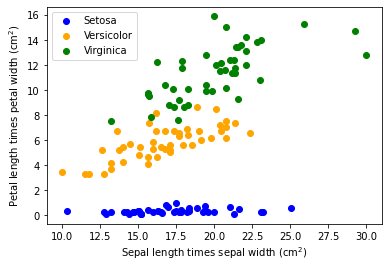

In [1207]:
figure, axes = plt.subplots()
axes.scatter(sepal_area.loc[target==0], petal_area.loc[target==0], label="Setosa", color="blue")
axes.scatter(sepal_area.loc[target==1], petal_area.loc[target==1], label="Versicolor", color="orange")
axes.scatter(sepal_area.loc[target==2], petal_area.loc[target==2], label="Virginica", color="green")
axes.set_xlabel("Sepal length times sepal width (cm$^2$)")
axes.set_ylabel("Petal length times petal width (cm$^2$)")
axes.legend()

In [1208]:
# Non-linear (multi-class) SVM, because our original data cannot be separated in to classes using a linear one
svm = SVC(kernel="rbf", decision_function_shape="ovr")
svm.fit(data_preprocessed, target)

SVC()

In [1209]:
data_new = pd.DataFrame(data={"sepal_area" : sepal_area, "petal_area" : petal_area})
target_new = target.copy()
target_new[target_new != 0] = 1

nan_indices = data_new.T.isnull().any() # Get the indices of rows with missing values on any column
data_new = data_new[~nan_indices] # Remove values from data and target based on the retrieved indices
target_new = target_new[~nan_indices]

In [1210]:
data_new.head()

,sepal_area,petal_area
0,17.00,0.64
1,20.40,11.55
2,16.80,6.75
3,23.10,0.28
4,13.64,6.75


In [1211]:
target_new.head()

0    0
1    1
2    1
3    0
4    1
Name: class, dtype: int64

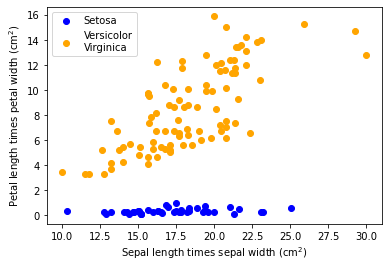

In [1212]:
figure, axes = plt.subplots()
axes.scatter(data_new.loc[target_new==0, "sepal_area"], data_new.loc[target_new==0, "petal_area"], label="Setosa", color="blue")
axes.scatter(data_new.loc[target_new==1, "sepal_area"], data_new.loc[target_new==1, "petal_area"], label="Versicolor\nVirginica", color="orange")
axes.set_xlabel("Sepal length times sepal width (cm$^2$)")
axes.set_ylabel("Petal length times petal width (cm$^2$)")
axes.legend()

In [1213]:
# Linear SVM for the modified data (from 4 features to 2 features)
svm_linear = SVC(kernel="linear", decision_function_shape="ovr")
svm_linear.fit(data_new, target_new)

SVC(kernel='linear')

In [1214]:
# These are the calculated points that help us build our SVM, by maximizing the margin around the hyperplane classifying our data.
print(svm_linear.support_vectors_) 

[[10.35  0.39]
 [17.5   0.96]
 [12.75  3.3 ]]


In [1215]:
 # Feature weights
w1 = svm_linear.coef_[0, 0]
w2 = svm_linear.coef_[0, 1]
b = svm_linear.intercept_[0]  # Bias-term, or offset
print(f"""Weight 1: {w1} 
Weight 2: {w2}
Bias-term: {b}
""")

print(f"""Equation of the decision boundary (hyperplane separating classes of data):  
{w1} * x1 + {w2} * x2 + ({b})
Where x1 and x2 are the respective input features.""") 

Weight 1: -0.05858215407149192 
Weight 2: 0.7355998927102397
Bias-term: -0.6807008398050046

Equation of the decision boundary (hyperplane separating classes of data):  
-0.05858215407149192 * x1 + 0.7355998927102397 * x2 + (-0.6807008398050046)
Where x1 and x2 are the respective input features.


In [1216]:
data_test = data_new[49:50]
predict_test = svm_linear.predict(data_test)
print(f"""Actual class: {target_new[49]}
Predicted class: {predict_test[0]}""")

data_test = data_new[127:128]
predict_test = svm_linear.predict(data_test)
print(f"""Actual class: {target_new[127]}
Predicted class: {predict_test[0]}""")

svm_accuracy = svm.score(data_preprocessed, target)
svm_linear_accuracy = svm_linear.score(data_new, target_new)
print(f"""SVM (non-linear or kernelized) accuracy for original data: {svm_accuracy}
SVM (linear) accuracy for modified data: {svm_linear_accuracy}""")


Actual class: 1
Predicted class: 1
Actual class: 1
Predicted class: 1
SVM (non-linear or kernelized) accuracy for original data: 0.98
SVM (linear) accuracy for modified data: 1.0


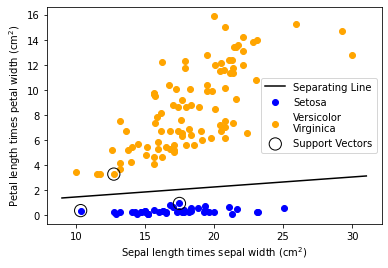

In [1217]:
figure, axes = plt.subplots()
axes.scatter(data_new.loc[target_new==0, "sepal_area"], data_new.loc[target_new==0, "petal_area"], label="Setosa", color="blue")
axes.scatter(data_new.loc[target_new==1, "sepal_area"], data_new.loc[target_new==1, "petal_area"], label="Versicolor\nVirginica", color="orange")
axes.set_xlabel("Sepal length times sepal width (cm$^2$)")
axes.set_ylabel("Petal length times petal width (cm$^2$)")

# Plot the SVM support vectors and SVM separation line
axes.scatter(svm_linear.support_vectors_[:,0],
           svm_linear.support_vectors_[:,1], marker='o', s=150,
           facecolors='none', edgecolors='black', label='Support Vectors')
svm_line = (lambda x: -(w1 / w2) * x - b) # w1, w2 and b are the parameters extracted from the trained SVM earlier
x1_lim = axes.get_xlim() # X axis view-limit
x1_range = np.linspace(x1_lim[0], x1_lim[1], 50) # Get an array of 50 linearly spaced points
x2 = svm_line(x1_range) # Apply the line lambda function to the range to transform it into the line separating the data points
axes.plot(x1_range, x2, color='black', label='Separating Line')

axes.legend()